In [1]:
import pickle
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

In [2]:
df = pd.read_csv('../app/data/HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
features_df = pd.get_dummies(data=df.iloc[:, :-1], drop_first=True)
dependent_df = df.iloc[:, -1]

In [4]:
features_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0


In [5]:
X = features_df.values
y = dependent_df.values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=1)

In [18]:
X_train.shape

(10499, 17)

In [19]:
X_test.shape

(4500, 17)

In [28]:
classifier_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=140,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.9,
    colsample_bylevel=0.9,
    colsample_bynode=0.9,
    objective='multi:softprob',
    scale_pos_weight=1,
    seed=None)

In [29]:
param_test = {
 'max_depth':[10, 11],
 'learning_rate': [0.15, 0.17, 0.2],
 'n_estimators': [230, 250, 270, 290],
 'min_child_weight': [1] #range(1,6,2)
}

In [30]:
#self_scorer = make_scorer(score_func=f1_score, average='weighted')
self_scorer = make_scorer(score_func=precision_score, average='weighted')
#self_scorer = make_scorer(score_func=recall_score, average='weighted')

In [31]:
grid_search = GridSearchCV(
    estimator=classifier_model,
    param_grid = param_test,
    scoring=self_scorer, #'roc_auc' | f1 | recall | accuracy
    n_jobs=7,
    cv=4)
grid_search.fit(X=X_train, y=y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.9,
                                     colsample_bynode=0.9, colsample_bytree=0.9,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=5,
                                     min_child_weight=1, missing=None,
                                     n_estimators=140, n_jobs=1, nthread=None,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=7,
             param_grid={'learning_rate': [0.13, 0.15],
                         'max_depth': [10, 11, 12], 'min_child_weight': [1],
   

In [32]:
grid_search.best_params_

{'learning_rate': 0.15,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 230}

In [38]:
grid_search.best_score_

0.5851980370003091

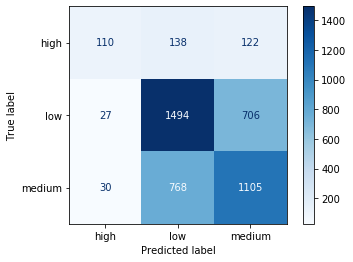

In [39]:
plot_confusion_matrix(
    estimator=grid_search.best_estimator_,
    X=X_test,
    y_true=y_test,
    cmap='Blues',
    values_format='.4g')

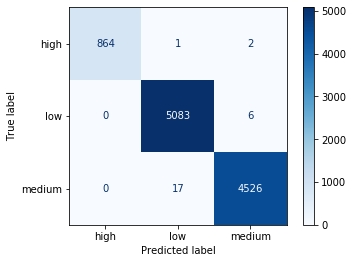

In [40]:
plot_confusion_matrix(
    estimator=grid_search.best_estimator_,
    X=X_train,
    y_true=y_train,
    cmap='Blues',
    values_format='.4g')

In [41]:
pickle.dump(grid_search.best_estimator_, open('model.pickle', 'wb'))